In [22]:
from PIL import Image
import numpy as np
import scipy.io.wavfile as wav
from scipy.signal import hamming
import matplotlib.pyplot as plt
import  python_speech_features as psf
import json

In [32]:
img = np.copy(np.asarray(Image.open('gray_spec_p2i_gen_scale_4.png'))).astype(np.float) ## loading image generated by singan

In [33]:
img.shape

(129, 368, 4)

In [34]:
img = img[:,:,0:3] ## dropping the 4th channel

In [35]:
img.shape

(129, 368, 3)

In [36]:
def audioread(filename):
    (rate,sig) = wav.read(filename)
    if sig.dtype == 'int16':
        nb_bits = 16
    elif sig.dtype == 'int32':
        nb_bits = 32
    max_nb_bit = float(2 ** (nb_bits - 1))
    sig = sig/(max_nb_bit+1.0)

    return rate, sig

def normhamming(fft_len):
    if fft_len == 512:
        frame_shift = 160
    elif fft_len == 256:
        frame_shift = 128
    else:
        print("Wrong fft_len, current only support 16k/8k sampling rate wav")
        exit(1)
    win = np.sqrt(hamming(fft_len, False))
    win = win/np.sqrt(np.sum(np.power(win[0:fft_len:frame_shift],2)))
    return win

def extract(filename, FFT_LEN, FRAME_SHIFT):
    # extract mag for mixture
    rate, sig = audioread(filename)
    frames = psf.sigproc.framesig(sig, FFT_LEN, FRAME_SHIFT, lambda x: normhamming(x))
#    frames = framesig(sig, FFT_LEN, FRAME_SHIFT, lambda x: normhamming(x))
#    phase, mag_spec = magspec(frames, FFT_LEN)
    complex_spec = np.fft.rfft(frames, FFT_LEN)
    phase        = np.angle(complex_spec)
    mag_spec     = np.absolute(complex_spec)

    return phase, mag_spec, rate, sig

def reconstruct(enhan_spec, phase, FFT_LEN, FRAME_SHIFT):

  # following is a sanity check, realising why ONLY strong spectral values
  # phase are important, and the rest we can set to zero. :)
  threshold_val = 0.001*enhan_spec.max()
  threshold     = threshold_val*np.ones(enhan_spec.shape)
  my_mask       = ((enhan_spec - threshold) > 0)
  my_phase      = phase * my_mask
  print('max enhan spec = ', enhan_spec.max(), 'and threshold =', threshold_val)
  nr,nc = my_mask.shape
  numElements = nr*nc
  print('number of spectra bin > threshold = ', my_mask.sum(),' as percentage = ',my_mask.sum()/numElements)

  fig, ax = plt.subplots(2, 1)
  ax[0].plot(my_mask)
  ax[1].plot(my_phase)
  plt.show()

  spec_comp = enhan_spec * np.exp(my_phase * 1j)
  nb_bits = 16
  enhan_frames = np.fft.irfft(spec_comp)
  enhan_sig = psf.sigproc.deframesig(enhan_frames, 0, FFT_LEN, FRAME_SHIFT, lambda x: normhamming(x))
  enhan_sig = enhan_sig / np.max(np.abs(enhan_sig)) * 0.8
  # above is simply to get the amplitude to normalize to some reasonable value
  max_nb_bit = float(2 ** (nb_bits - 1))
  enhan_sig = enhan_sig * (max_nb_bit - 1.0)
  if nb_bits == 16:
      enhan_sig = enhan_sig.astype(np.int16)
  elif nb_bits == 32:
      enhan_sig = enhan_sig.astype(np.int32)

  return enhan_sig

def unscale_minmax(X, X_min, X_max, min=0.0, max=1.0):
    X = X.astype(np.float)
    X -= min
    X /= (max - min)
    X *= (X_max - X_min)
    X += X_min
    return X

In [37]:
## we need to do this just to get the phase, required for reconstruction

orig_file = 'noisy_audio.wav' # this was the origiinal training sample
sample_rate  = 8000
FFT_LEN      = 256
FRAME_SHIFT  = 128

# extract magnitude features
phase, mag_spec, rate, sig = extract(orig_file, FFT_LEN, FRAME_SHIFT)

In [38]:
img = np.mean(img, axis = 2) ## converting the image into a 1-channel by taking mean across the 3-channels

In [39]:
img.shape

(129, 368)

In [40]:
with open("data.json", "r") as ip:
    maxmin_dict = json.load(ip)

In [41]:
new_img = unscale_minmax(img, maxmin_dict['min'], maxmin_dict['max'], 0, 255)

In [42]:
new_img

array([[-46.01593386, -42.62166509, -42.76309296, ..., -48.7030633 ,
        -42.62166509, -37.81311767],
       [-52.23875994, -48.56163544, -47.14735678, ..., -49.41020263,
        -46.15736172, -43.61166015],
       [-53.93589432, -52.66304353, -53.08732713, ..., -46.29878959,
        -47.14735678, -48.56163544],
       ...,
       [-65.10869569, -72.60437256, -75.71578559, ..., -66.80583007,
        -72.46294469, -75.15007413],
       [-65.10869569, -73.31151188, -76.84720852, ..., -73.02865615,
        -81.51432808, -84.20145752],
       [-64.68441209, -75.15007413, -79.95862156, ..., -80.94861661,
        -90.        , -90.        ]])

In [43]:
m_spec = new_img/20
m_spec = 10**m_spec
m_spec = np.transpose(m_spec)

In [44]:
m_spec

array([[5.00268672e-03, 2.44377942e-03, 2.01004270e-03, ...,
        5.55348004e-04, 5.55348004e-04, 5.83148812e-04],
       [7.39463506e-03, 3.73179886e-03, 2.32727564e-03, ...,
        2.34304901e-04, 2.15985405e-04, 1.74781835e-04],
       [7.27520696e-03, 4.39169490e-03, 2.21632601e-03, ...,
        1.63761090e-04, 1.43760500e-04, 1.00477523e-04],
       ...,
       [3.67152792e-03, 3.38446376e-03, 4.84239843e-03, ...,
        4.56781489e-04, 2.23134741e-04, 8.96538965e-05],
       [7.39463506e-03, 4.92189012e-03, 4.39169490e-03, ...,
        2.38151195e-04, 8.40008337e-05, 3.16227766e-05],
       [1.28630547e-02, 6.59807112e-03, 3.73179886e-03, ...,
        1.74781835e-04, 6.16491544e-05, 3.16227766e-05]])

max enhan spec =  7.014121947717493 and threshold = 0.007014121947717493
number of spectra bin > threshold =  23961  as percentage =  0.5047396359959555


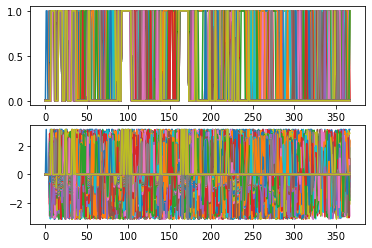

In [45]:
enhan = reconstruct(m_spec, phase, FFT_LEN, FRAME_SHIFT)

In [46]:
sav = 'cust_rand.wav'
wav.write(sav, rate, enhan)

In [47]:
import librosa.display

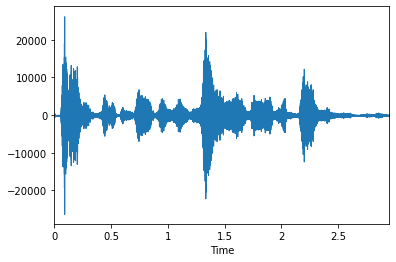

In [48]:
librosa.display.waveplot(enhan.astype(float), sr = rate)

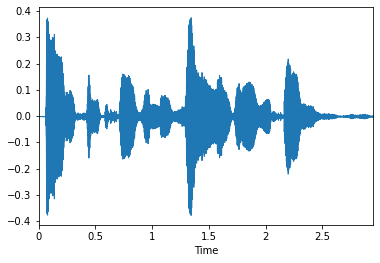

In [49]:
y, sr = librosa.load('clean_audio.wav')
librosa.display.waveplot(y, sr)